<div>
    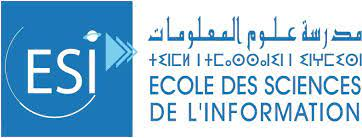
</div>

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;">
<p style="color:orange;font-weight:bold"><u>Réalisé par:</u></p>
<ul >
    <li>ELGHAZI Soufiane</li>
    <li>MAASRI Amine</li>
    <li>Dahmou Youssef</li>
    <li>OUAHIB Yassine</li>
</ul>
    
</div>

<h1 style='color:purple' align='center'>Projet Text mining: News SUM </h1>

<h2 style='color:olive' align='center'>BART avec la fonctionalité de NER </h2>

<div style="background-color:white; color:black; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;">
<p style="color:purple;">Étape 3 : Amélioration de modèle : BART avec NER</p><br>
<p style="color:purple;">Références</p>
 Les liens vers les ressources utilisées et consulté .<br><br>
</div>

<h2 style='color:purple'>Importation des Bibliothèques: </h2>

In [6]:
pd.set_option('display.max_colwidth', 1000)

seed = 42
colormap = 'cividis'
template = 'plotly_dark'

# Checking if GPU is available
if torch.cuda.is_available():
    print("GPU is available. \nUsing GPU")
    device = torch.device('cuda')
else:
    print("GPU is not available. \nUsing CPU")
    device = torch.device('cpu')

GPU is available. 
Using GPU


In [2]:
!python -m spacy download en_core_web_sm
!pip install spacy
!pip install spacy
#!pip install datasets # Installing the datasets library (https://huggingface.co/docs/datasets/index)
!pip install evaluate # Installing the evaluate library (https://huggingface.co/docs/evaluate/main/en/index)
!pip install transformers # Installing the transformers library (https://huggingface.co/docs/transformers/index)
!pip install rouge-score # Installing rouge-score library (https://pypi.org/project/rouge-score/)
!pip install py7zr # Installing library to save zip archives (https://pypi.org/project/py7zr/)
!pip install datasets

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 71.6 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
# Importing Libraries

# Data Handling
import pandas as pd
import numpy as np
from datasets import Dataset, load_metric
import shutil

# Data Visualization
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.io as pio
from IPython.display import display
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Statistics & Mathematics
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import shapiro, skew, anderson, kstest, gaussian_kde,spearmanr
import math

# Hiding warnings
import warnings
warnings.filterwarnings("ignore")
# Transformers
from transformers import BartTokenizer, BartForConditionalGeneration      # BERT Tokenizer and architecture
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments         # These will help us to fine-tune our model
from transformers import pipeline                                         # Pipeline
from transformers import DataCollatorForSeq2Seq                           # DataCollator to batch the data 
import torch                                                              # PyTorch
import evaluate                                                           # Hugging Face's library for model evaluation


# Other NLP libraries
from textblob import TextBlob                                             # This is going to help us fix spelling mistakes in texts
from sklearn.feature_extraction.text import TfidfVectorizer               # This is going to helps identify the most common terms in the corpus
import re                                                                 # This library allows us to clean text data
import nltk                                                               # Natural Language Toolkit
nltk.download('punkt')                                                    # This divides a text into a list of sentences
import spacy
import pandas as pd
from transformers import BartTokenizer, BartForConditionalGeneration, DataCollatorForSeq2Seq
from sklearn.model_selection import train_test_split
from datasets import Dataset
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BartTokenizer, BartForConditionalGeneration
from datasets import Dataset, load_metric
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from transformers import DataCollatorForSeq2Seq
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Partie 1 : Chargement et prétraitement des données
</div>

In [8]:
from sklearn.model_selection import train_test_split
import pandas  as pd 
data_path = '/kaggle/input/cleaned-corpus/cleaned_corpus.xlsx'
df = pd.read_excel(data_path)

In [9]:
df.columns = ['Content','Summary']

> ### - Le code suivant nous permet de déterminer la longueur maximale des articles de notre dataset. Nous utilisons cette information pour configurer les entrées et les sorties de notre modèle.

In [58]:
def max_length_per_column(dataframe):
    max_lengths = {}
    for column in dataframe.columns:
        max_lengths[column] = dataframe[column].astype(str).apply(len).max()
    return max_lengths
max_lengths = max_length_per_column(df)
print("Max Lengths per Column:")
print(max_lengths)


Max Lengths per Column:
{'Content': 330704, 'Summary': 1853, 'Entities': 37047}


<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Partie 2 : Reconnaissance d'entités nommées (NER):
</div>

In [11]:
nlp = spacy.load("en_core_web_sm")

In [12]:

def extract_entities(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents]
    return entities
df['Entities'] = df['Content'].apply(extract_entities)

In [56]:
df.head(3)

,Content,Summary,Entities
0,it s heartbreaking. initial surveys indicated ef-3 tornado damage in east nashville nashville s donelson neighborhood and in mt as of tuesday evening 18 people were reported dead in putnam county three in wilson county two in davidson county and one in benton county the tennessee emergency management authority said robin fugett and her husband ran to the basement of their east nashville home early tuesday when they heard swirling wind in davidson county where nashville is and wilson county voting was delayed one hour because of the storms officials said wtvfmetro nashville public schools are closed due to tornado damage throughout the city the district said.,severe storms and at least one tornado slammed through central tennessee killing 24 people and wrecking hundreds of buildings hours before dawn on tuesday it s tragic day in our state gov bill lee told reporters it s heartbreaking. initial surveys indicated ef-3 tornado damage in east nashville nashville s donelson neighborhood and in mt juliet town about 20 miles east of nashville the national weather service said among the victims was couple who was hit by debris shortly after they left the attaboy lounge an east nashville cocktail bar where one of them worked the metro nashville police department said they were identified as michael dolfini 36 and his girlfriend albree sexton 33 as of tuesday evening 18 people were reported dead in putnam county three in wilson county two in davidson county and one in benton county the tennessee emergency management authority said the agency said one death previously reported in putnam county was not storm related putnam county officials have...,"[nashville, mt, tuesday, 18, three, wilson county, two, davidson county, one, benton county, the tennessee emergency management authority, robin fugett, early tuesday, davidson county, nashville, wilson county, one hour, nashville]"
1,by the time the tornado siren sounded one week ago the roof of sydney moore s mobile home in clarksville tennessee had been sheared off and her 4-month-old son lord sucked up by the twister moments before the clarksville tornado touched down moore youngblood and the boys were relaxing in her mobile home tornado passes in front of storm chasers in clarksville tennessee last saturday it s really so comforting sydney moore said like an angel guided him safely to that spot. in an interview caitlyn moore said it s miracle lord is alive.,by the time the tornado siren sounded one week ago the roof of sydney moore s mobile home in clarksville tennessee had been sheared off and her 4-month-old son lord sucked up by the twister there was no warning said moore 22 who immediately moved to shield her 1-year-old son princeton with her body moore s boyfriend aramis youngblood 39 rushed to protect lord who was sleeping in bassinet swept up in swirl of wind and debris saturday evening as series of powerful tornadoes and storms tore through the state the walls of moore s mobile home came down next the roar of shredding winds was punctuated by pounding rains youngblood reaching for the bassinet also was lifted off the ground and hurtled through the air moore recalled moore cradling her 1-year-old son climbed out from beneath the remains of the crushed mobile home my kids never cry they re such good babies she said i was trying to get us out he wasn t even crying. youngblood his shoulder dislocated spent an agonizing 10 minu...,"[one week ago, sydney moore s, clarksville tennessee, 4-month-old, clarksville tennessee, last saturday, sydney moore]"
2,it s heartbreaking. initial surveys indicated ef-3 tornado damage in east nashville nashville s donelson neighborhood and in mt as of tuesday evening 18 people were reported dead in putnam county three in wilson county two in davidson county and one in benton county the tennessee emergency management authority said robin fugett and her husband ran to the basement of their east nashville home early tuesday when t

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Partie 3 : Tokenisation et la Répartition des données.
</div>

In [14]:
train, temp_data = train_test_split(df, test_size=0.2, random_state=42)
val, test = train_test_split(temp_data, test_size=0.5, random_state=42)

In [15]:
train_ds = Dataset.from_pandas(train)
test_ds = Dataset.from_pandas(test)
val_ds = Dataset.from_pandas(val)

> ### - Menommer la colonne "Enteties" en "Entetés".

In [16]:
train_ds = train_ds.rename_column('Entities', 'entities')
test_ds = test_ds.rename_column('Entities', 'entities')
val_ds = val_ds.rename_column('Entities', 'entities')

> ###  -  chargement du Bart modèle et le tokenizer 

In [17]:
checkpoint = 'facebook/bart-large-xsum'  # Model
tokenizer = BartTokenizer.from_pretrained(checkpoint)  # Loading Tokenizer
model = BartForConditionalGeneration.from_pretrained(checkpoint)  # Loading Model

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/309 [00:00<?, ?B/s]

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Injection de la colonne "entetes" dans l'entrée du modèle en se basant sur la concaténation des colonnes "Content" et "entetes".
</div>

In [18]:
def preprocess_function(examples):
    inputs = [content + " " + entities for content, entities in zip(examples["Content"], examples["entities"])]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["Summary"], max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [79]:
test_ds

Dataset({
    features: ['Content', 'Summary', 'entities', '__index_level_0__'],
    num_rows: 100
})

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
tokenization des données
</div>

In [19]:
def preprocess_function(examples):
    # Check if 'entities' is a list of strings or a list of lists
    if isinstance(examples["entities"][0], list):
        # Flatten the list of lists
        entities = [' '.join(entity_list) for entity_list in examples["entities"]]
    else:
        entities = examples["entities"]

    # Concatenate 'Content' and 'Entities'
    inputs = [content + " " + entity for content, entity in zip(examples["Content"], entities)]
    
    # Tokenize and preprocess inputs
    model_inputs = tokenizer(inputs, max_length=2000, truncation=True)

    with tokenizer.as_target_tokenizer():
        # Tokenize and preprocess 'Summary'
        labels = tokenizer(examples["Summary"], max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


# Tokenize and preprocess the datasets
tokenized_train = train_ds.map(preprocess_function, batched=True, remove_columns=['Content', 'entities', 'Summary'])
tokenized_test = test_ds.map(preprocess_function, batched=True, remove_columns=['Content', 'entities', 'Summary'])
tokenized_val = val_ds.map(preprocess_function, batched=True, remove_columns=['Content', 'entities', 'Summary'])


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
 la regroupement de données (DataCollatorForSeq2Seq) pour préparer les données séquentielles afin de faciliter l'entraînement du modèle de séquence à séquence.</div>

In [20]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Partie 6 : Fine-tuning du modèle</div>

In [40]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir='bart_samsum',
    evaluation_strategy="epoch",
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    seed=seed,
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=8,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=9,
    predict_with_generate=True,
    fp16=True,
    report_to="none"
)

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
L'instantiation de l'objet trainer utilise le modèle, les paramètres d'entraînement, les jeux de données d'entraînement et de validation, ainsi que le tokenizer et le data collator pour superviser le processus d'entraînement Seq2Seq.</div>

In [41]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Entraînement du modéle</div>

In [42]:
history = trainer.train()

Epoch,Training Loss,Validation Loss
0,No log,3.210102
1,No log,3.324137
2,1.360500,3.270472
4,1.360500,3.506397
5,1.132700,3.594978
6,1.132700,3.670992
8,0.802400,3.785352


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


> ### - Le modèle finement ajusté est sauvegardé dans le répertoire 

In [43]:
# Save the fine-tuned model
model.save_pretrained('/kaggle/working/models/ENR_BERT_model1')

In [45]:
# Load the fine-tuned model
fine_tuned_model = BartForConditionalGeneration.from_pretrained('/kaggle/working/models/ENR_BERT_model1')

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Évaluation du modèle</div>

In [46]:
# Evaluate the model on the validation dataset
results = trainer.evaluate()
results

{'eval_loss': 3.21010160446167,
 'eval_runtime': 7.4885,
 'eval_samples_per_second': 25.372,
 'eval_steps_per_second': 25.372,
 'epoch': 8.99}

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
Utilisation du modèle finement ajusté pour générer des résumés à partir du texte d'entrée fourni</div>

In [47]:
# Example: Generate summaries using the fine-tuned model
input_text = """By . Emma Innes . A cystic fibrosis patient has married his girlfriend after having a successful lung transplant. Dane Pollard, 34, was diagnosed with the condition when he was 18 months old and feared he would not survive. The condition caused his lungs to fill with mucus, meaning he needed daily physiotherapy in order to lead a normal life. Dane Pollard met and married his partner, Emma, after his life was saved by a last minute lung transplant . Mr Pollard was diagnosed with cystic fibrosis when he was 18 months old and his health slowly deteriorated . However, his health worsened and he found himself needing a wheelchair and additional oxygen. He eventually ended up housebound and was put on the lung transplant list. In 2008, he received a call to say that some new lungs had been found for him and the operation could go ahead. He believes that if the lungs had not become available, he would not have survived for many more days."""

def Summarizer(input_text):
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids

    # Generate the summary
    summary_ids = fine_tuned_model.generate(input_ids)

    # Decode the summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary
Summarizer(input_text)

'by. Emma Innes. a cystic fibrosis patient has married his girlfriend after having a successful lung transplant following his life-saving operation in 2008 Dane Pollard was diagnosed with the condition when he was 18 months old and feared he would not survive.'

##### Content : By . Emma Innes . A cystic fibrosis patient has married his girlfriend after having a successful lung transplant. Dane Pollard, 34, was diagnosed with the condition when he was 18 months old and feared he would not survive. The condition caused his lungs to fill with mucus, meaning he needed daily physiotherapy in order to lead a normal life. Dane Pollard met and married his partner, Emma, after his life was saved by a last minute lung transplant . Mr Pollard was diagnosed with cystic fibrosis when he was 18 months old and his health slowly deteriorated . However, his health worsened and he found himself needing a wheelchair and additional oxygen. He eventually ended up housebound and was put on the lung transplant list. In 2008, he received a call to say that some new lungs had been found for him and the operation could go ahead. He believes that if the lungs had not become available, he would not have survived for many more days.


In [48]:
data = pd.read_csv('/kaggle/input/news-summarization/data.csv')

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [50]:
dt= df.iloc[:30] #data
references = list(dt.Summary)
contents = list(dt.Content)

predictions = []
for cntnt in contents :
    predictions.append(Summarizer(cntnt[:1000]))
predictions

['severe storms and at least one tornado tore through central tennessee killing at least 18 people and wrecking hundreds of buildings early tuesday morning as severe storms and heavy rain moved across the state the national weather service said initial surveys indicated ef-3 tornado damage in east nashville',
 'by the time the tornado siren sounded one week ago the roof of sydney moore s mobile home in clarksville tennessee had been sheared off and her 4-month-old son lord sucked up by the twister and her two-year-old brother',
 'severe storms and at least one tornado tore through central tennessee killing at least 18 people and wrecking hundreds of buildings early tuesday morning as severe storms and heavy rain moved across the state the national weather service said initial surveys indicated ef-3 tornado damage in east nashville',
 'a powerful storm slammed the eastern seaboard on sunday bringing torrential rain and strong winds to the region causing flooding and disrupting the morni

<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
 BLEU Score:</div>

In [51]:
from nltk.translate import bleu_score
from rouge_score import rouge_scorer

bleu_score = bleu_score.corpus_bleu(references, predictions)
print("BLEU Score:", bleu_score)

BLEU Score: 0.5450022002835863


<h2 style='color:olive' align='center'>Références: </h2>

---
<div style="background-color:olive; color:white; font-size:15px; font-family:Verdana; padding:10px;font-weight:bold;border: 5px solid black;text-align:center">
<ul>
<li><a href="https://blog.research.google/2016/08/text-summarization-with-tensorflow.html" style="color:white;"> Ressource 1</a></li>
<li><a href="https://en.wikipedia.org/wiki/Tf%E2%80%93idf" style="color:white;"> Ressource 2</a></li>
<li><a href="https://www.kaggle.com/datasets/sbhatti/news-summarization/data" style="color:white;"> Ressource 3 </a></li>
<li><a href="https://radimrehurek.com/gensim/models/word2vec.html" style="color:white;"> Ressource4 </a></li>
    
</ul>
</div>

---

<h2 style='color:olive' align='center'>END </h2>